In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.0 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
audio_files_path = "/content/drive/MyDrive/DeepFake Voice/KAGGLE/AUDIO"


In [8]:
folders = os.listdir(audio_files_path)
print(folders)

['REAL', 'FAKE']


In [9]:
real_audio = "/content/drive/MyDrive/DeepFake Voice/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
fake_audio = "/content/drive/MyDrive/DeepFake Voice/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

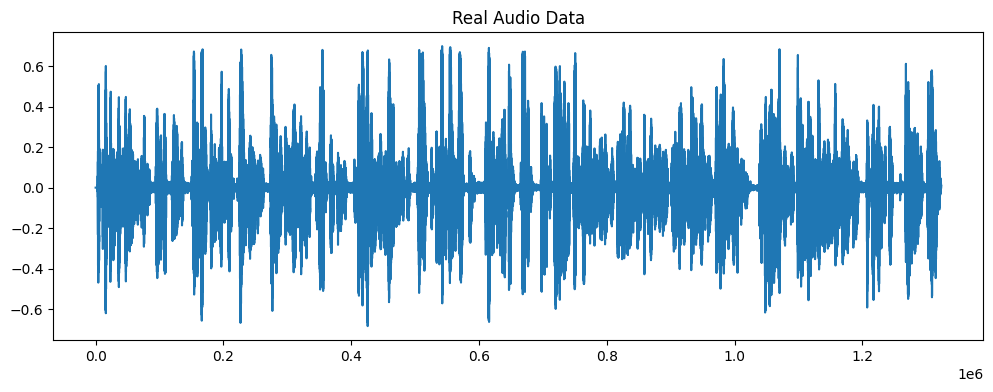

In [10]:
real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize=(12, 4))
plt.plot(real_ad)
plt.title("Real Audio Data")
plt.show()

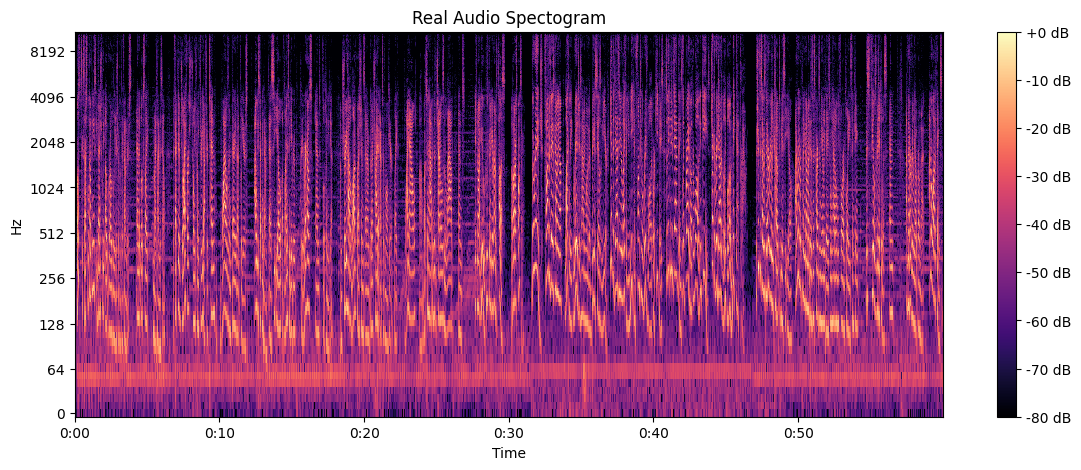

In [11]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectogram")
plt.show()

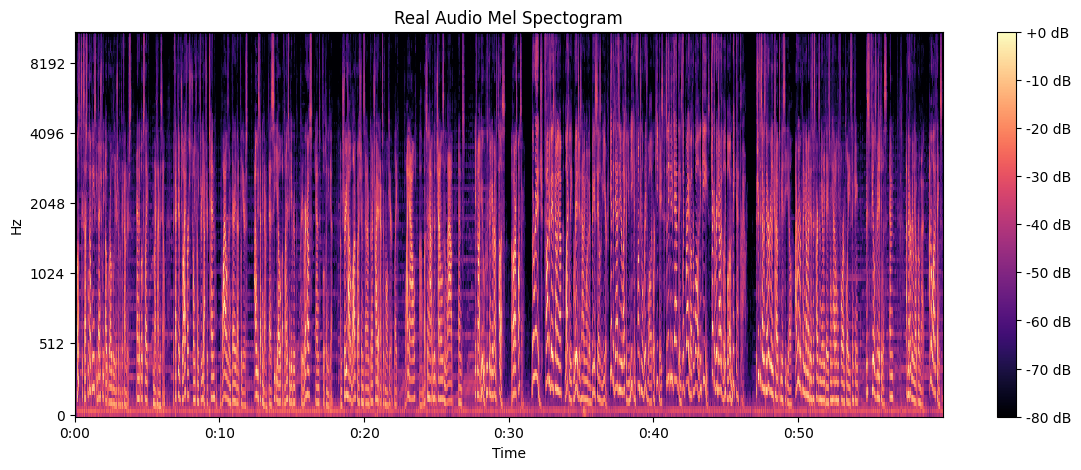

In [12]:
real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mel_spect, y_axis="mel", x_axis="time")
plt.title("Real Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

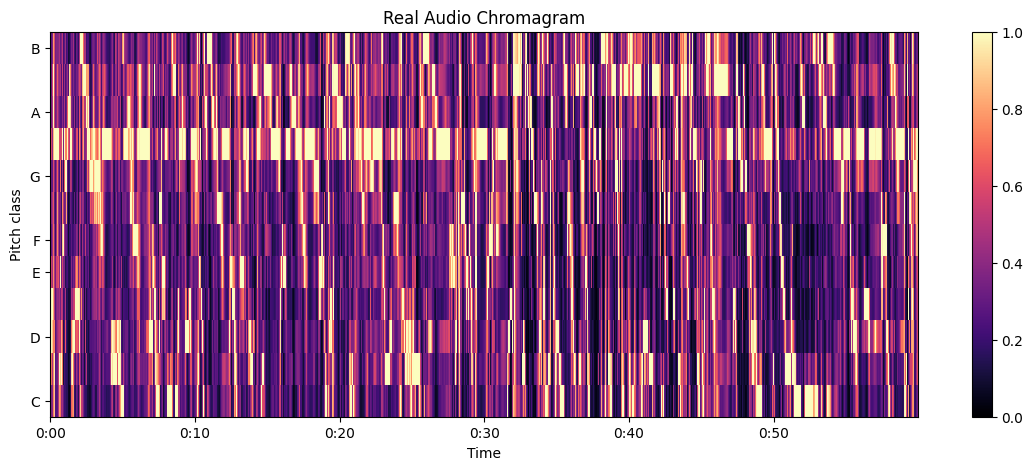

In [13]:
real_chroma = librosa.feature.chroma_cqt(y=real_ad, sr=real_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_chroma, sr=real_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Real Audio Chromagram")
plt.show()

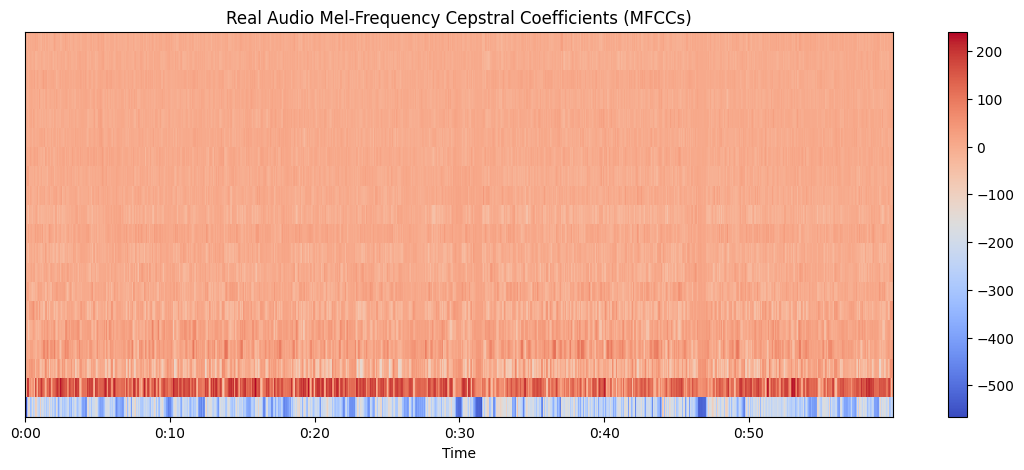

In [14]:
real_mfccs = librosa.feature.mfcc(y=real_ad, sr=real_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mfccs, sr=real_sr, x_axis="time")
plt.colorbar()
plt.title("Real Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

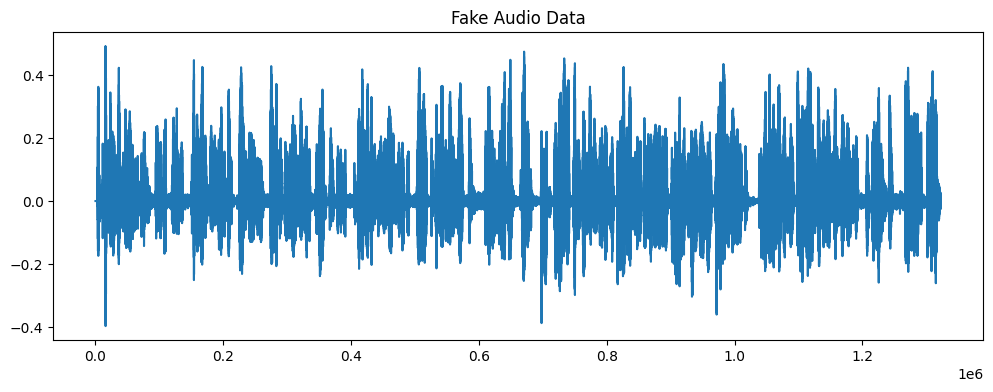

In [15]:
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize=(12, 4))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

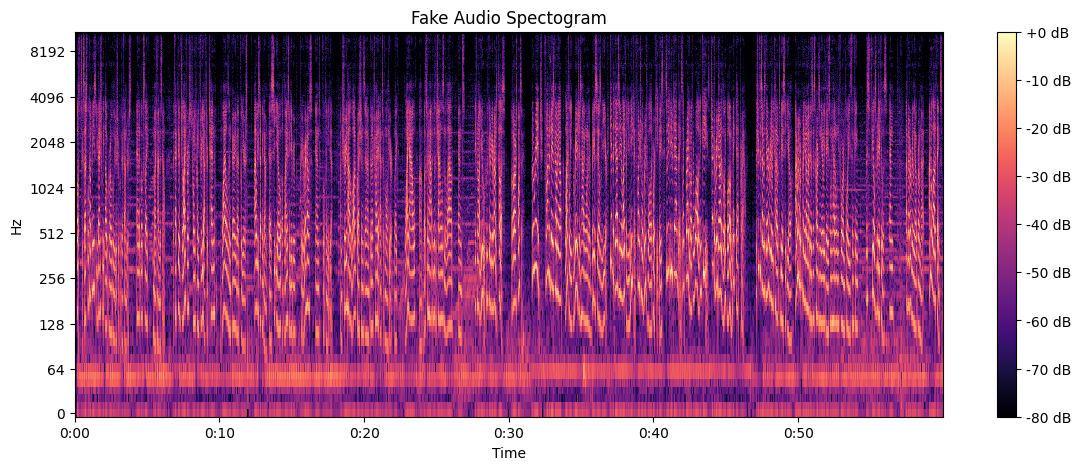

In [16]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_spec, sr=fake_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Spectogram")
plt.show()

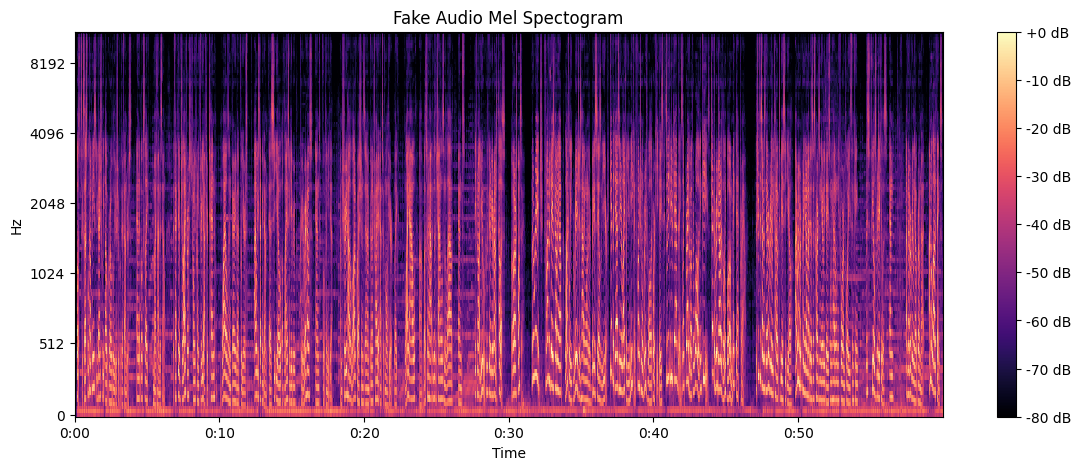

In [17]:
fake_mel_spect = librosa.feature.melspectrogram(y=fake_ad, sr=fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mel_spect, y_axis="mel", x_axis="time")
plt.title("Fake Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

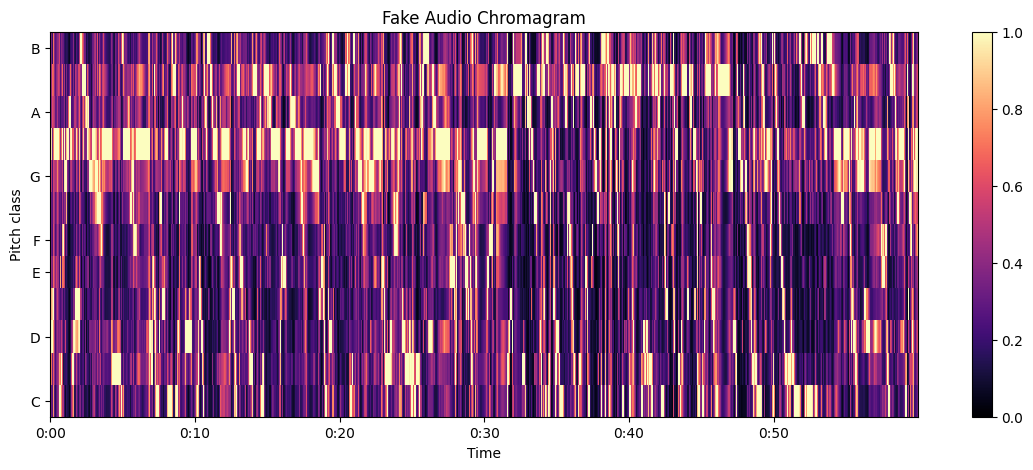

In [18]:
fake_chroma = librosa.feature.chroma_cqt(y=fake_ad, sr=fake_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_chroma, sr=fake_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Fake Audio Chromagram")
plt.show()

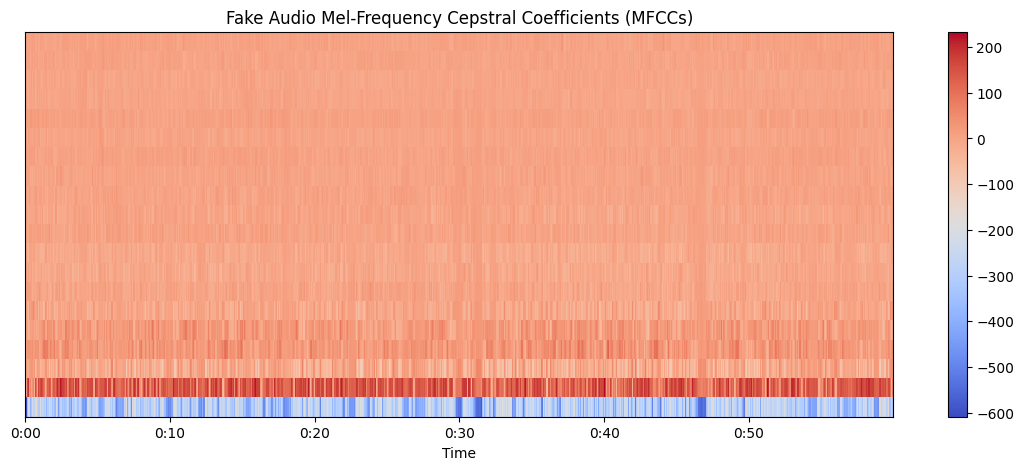

In [19]:
fake_mfccs = librosa.feature.mfcc(y=fake_ad, sr=fake_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mfccs, sr=fake_sr, x_axis="time")
plt.colorbar()
plt.title("Fake Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

In [20]:
data = []
labels = []

for folder in folders:
    files = os.listdir(os.path.join(audio_files_path, folder))
    for file in tqdm(files):
        file_path = os.path.join(audio_files_path, folder, file)
        audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast")
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_features_scaled = np.mean(mfccs_features.T, axis=0)
        data.append(mfccs_features_scaled)
        labels.append(folder)

100%|██████████| 56/56 [08:37<00:00,  9.25s/it]


In [21]:
feature_df = pd.DataFrame({"features": data, "class": labels})
feature_df.head()

,features,class
0,"[-275.00848, 117.23315, -52.507126, -7.438482,...",REAL
1,"[-256.93, 115.666626, -4.39025, 26.249256, 6.7...",REAL
2,"[-278.74802, 93.562225, -29.730576, 21.363153,...",REAL
3,"[-248.25002, 168.32622, -16.75881, 21.82504, 1...",REAL
4,"[-353.45502, 102.8698, -17.037445, 13.006072, ...",REAL


In [22]:
feature_df["class"].value_counts()

,count
class,
FAKE,56
REAL,8


In [23]:
def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

In [24]:
feature_df["class"] = label_encoder(feature_df["class"])

class ['FAKE' 'REAL']


In [25]:
X = np.array(feature_df["features"].tolist())
y = np.array(feature_df["class"].tolist())

In [26]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [27]:
y_resampled = to_categorical(y_resampled)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [29]:
num_labels = len(feature_df["class"].unique())
num_labels

2

In [30]:
input_shape = feature_df["features"][0].shape
input_shape

(40,)

In [31]:
model = Sequential()
model.add(Dense(128, input_shape=input_shape))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_labels))
model.add(Activation(activation="softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,426 (279.01 KB)

 Trainable params: 71,426 (279.01 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
early = EarlyStopping(monitor="accuracy", patience=10)


In [52]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=4, epochs=100, callbacks=[early])


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8714 - loss: 0.2522 - val_accuracy: 0.9565 - val_loss: 0.0704
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8940 - loss: 0.1292 - val_accuracy: 0.8696 - val_loss: 0.1150
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7775 - loss: 0.3270 - val_accuracy: 0.9565 - val_loss: 0.0894
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9658 - loss: 0.0829 - val_accuracy: 0.9565 - val_loss: 0.0765
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9015 - loss: 0.1196 - val_accuracy: 0.9565 - val_loss: 0.0547
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8615 - loss: 0.2266 - val_accuracy: 0.9565 - val_loss: 0.0457
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8536 - loss: 0.1733 - val_accuracy: 0.9130 - val_loss: 0.0832
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8786 - loss: 0.1523 - val_accuracy: 0.9130 

In [54]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9130 - loss: 0.0960
Test Loss: 0.09598957002162933
Test Accuracy: 0.9130434989929199


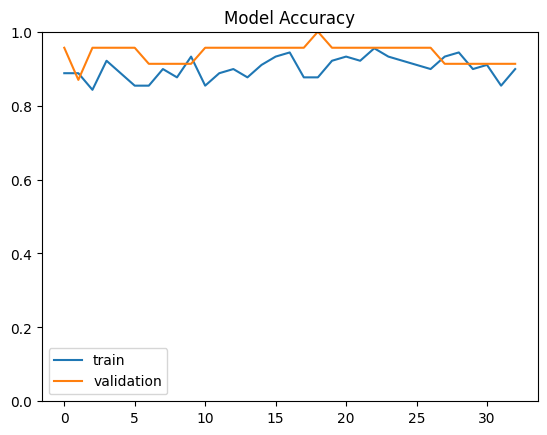

In [55]:
plt.figure()
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

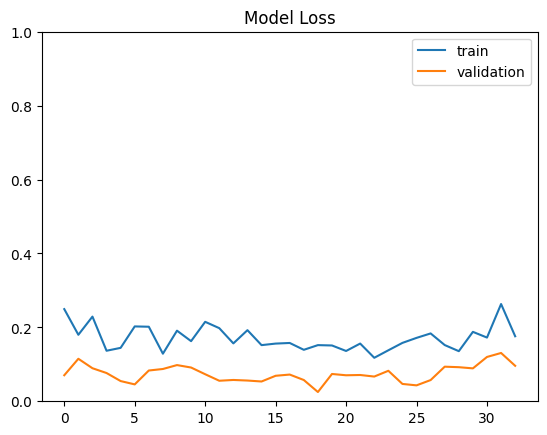

In [56]:
plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

In [57]:
def detect_fake(filename):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
    mfccs_features_scaled = mfccs_features_scaled.reshape(1, -1)
    result_array = model.predict(mfccs_features_scaled)
    print(result_array)
    result_classes = ["FAKE", "REAL"]
    result = np.argmax(result_array[0])
    print("Result:", result_classes[result])

In [58]:
test_real = "/content/drive/MyDrive/DeepFake Voice/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
test_fake = "/content/drive/MyDrive/DeepFake Voice/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

In [59]:
detect_fake(test_real)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
[[3.4797566e-05 9.9996519e-01]]
Result: REAL


In [60]:
detect_fake(test_fake)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[[1.000000e+00 1.705075e-08]]
Result: FAKE


In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Reshape
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [62]:
# Reshape the data for CNN input (assuming MFCC features are used)
X_train_cnn = X_train.reshape(-1, 40, 1, 1)
X_test_cnn = X_test.reshape(-1, 40, 1, 1)


In [111]:
# CNN Model
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(40, 1, 1)),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 1)),
        Dropout(0.3),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 1)),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(y_train.shape[1], activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [112]:
# Build and Train the Model
cnn_model = build_cnn_model()
cnn_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 40, 1, 32)           │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 40, 1, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 20, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 20, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 20, 1, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 20, 1, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 10, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 10, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,506 (396.51 KB)

 Trainable params: 101,314 (395.76 KB)

 Non-trainable params: 192 (768.00 B)

In [113]:
history = cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=16, validation_data=(X_test_cnn, y_test))


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.4410 - loss: 1.7392 - val_accuracy: 0.5652 - val_loss: 1.1725
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4589 - loss: 1.4303 - val_accuracy: 0.5652 - val_loss: 0.6919
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5481 - loss: 1.0873 - val_accuracy: 0.6087 - val_loss: 0.6466
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6170 - loss: 0.8901 - val_accuracy: 0.6522 - val_loss: 0.6331
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6295 - loss: 0.8619 - val_accuracy: 0.6087 - val_loss: 0.5977
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6357 - loss: 0.9358 - val_accuracy: 0.4783 - val_loss: 0.8148
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6444 - loss: 0.7146 - val_accuracy: 0.4348 - val_loss: 0.8940
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6445 - loss: 0.6394 - val_accuracy: 0.5652 - val_loss: 0.7111

In [114]:
# Evaluate Model
loss, accuracy = cnn_model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8696 - loss: 0.1877
Test Accuracy: 0.8696


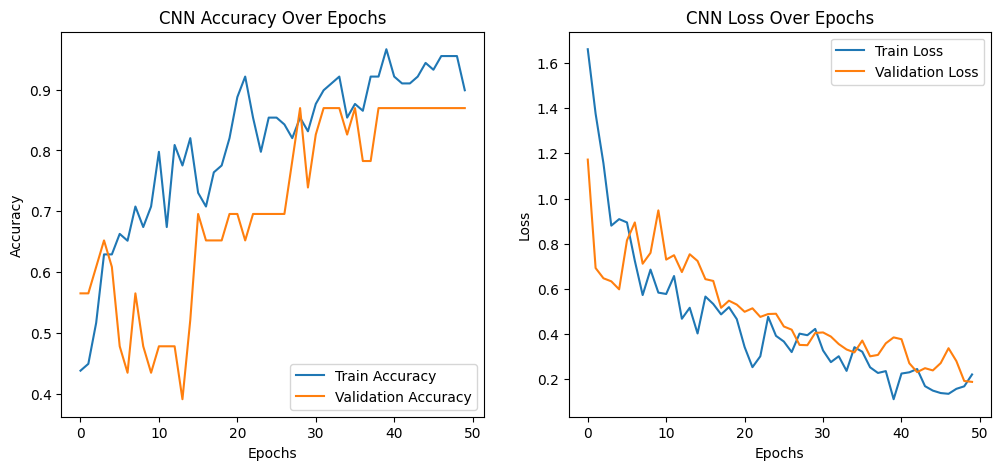

In [115]:
# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN Loss Over Epochs')

plt.show()

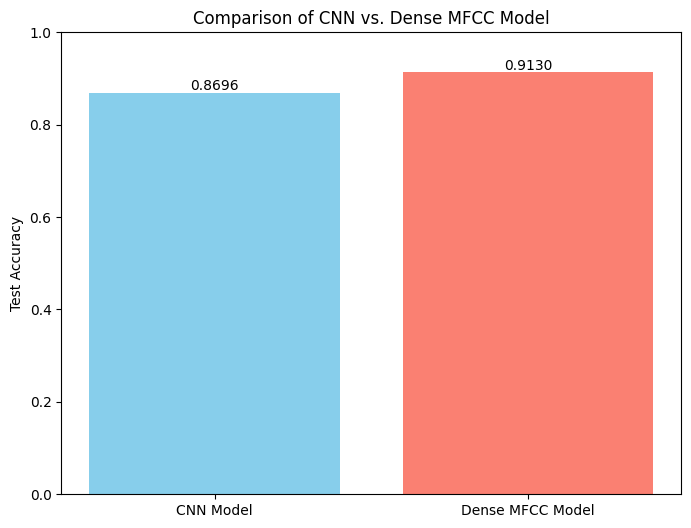

In [116]:
import matplotlib.pyplot as plt

# Evaluate CNN model to get acc_cnn
loss_cnn, acc_cnn = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)

# Assuming 'model' from your global variables is the Dense MFCC Model
loss_mfcc, acc_mfcc = model.evaluate(X_test, y_test, verbose=0)

models = ['CNN Model', 'Dense MFCC Model']
accuracies = [acc_cnn, acc_mfcc]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Test Accuracy')
plt.title('Comparison of CNN vs. Dense MFCC Model')

# Annotate each bar with its accuracy
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}',
             ha='center', va='bottom')

plt.show()